# Time series analysis - Example code 15: Predicting a BJ model

**Lund University, Lund, Sweden**

**Note:** Python uses a slightly different notation for the BJ model as compared to that used in the course. In the notation used here:

A(z) y(t) = [B(z)/F(z)] u(t) + [C(z)/D(z)] e(t)

This means that:
- A(z) = 1,       B(z) = B(z),    F(z) = A2(z)
- C(z) = C1(z),   D(z) = A1(z)

**Reference:**  
"An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson  
Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

import sys
sys.path.append('../TimeSeriesAnalysis-main/TimeSeriesAnalysis-main')


from tsa_lth.modelling import estimateARMA, estimateBJ
from tsa_lth.analysis import acf, pacf, plotACFnPACF, xcorr, naive_pred
from tsa_lth.tests import whiteness_test, check_if_normal
from tsa_lth.tools.poly import polydiv

## Simulate some processes

In [2]:
np.random.seed(50)                               # Set the seed (just done for the lecture!)

extraN = 1000                                   # Lets check again why we do this; try removing this.
N = 1300
noLags = 30
modelLim = 1000                                 # Determine where the validation data starts.

# Simulate some process.
sX = 24
A1 = np.array([1, -1.8, 0.82])
C1 = np.array([1, 0, -0.8])
A3 = np.convolve(np.concatenate([[1], np.zeros(sX-1), [-1]]), [1, -0.4])
C3 = np.array([1, 0.8, 2.1])
B = np.array([1.2])
A2 = np.array([1])

# Generate the noise and the input signals.
z = lfilter(C1, A1, np.random.randn(N + extraN))    # This is the noise model.
x = lfilter(C3, A3, np.random.randn(N + extraN))    # This is the input signal.

# Form the output using the filtered input. Remove the initial samples.
y = lfilter(B, A2, x) + z
y = y[extraN:]
x = x[extraN:]
xM = x[:modelLim]                               # Extract model data.
yM = y[:modelLim]

## Examine the data

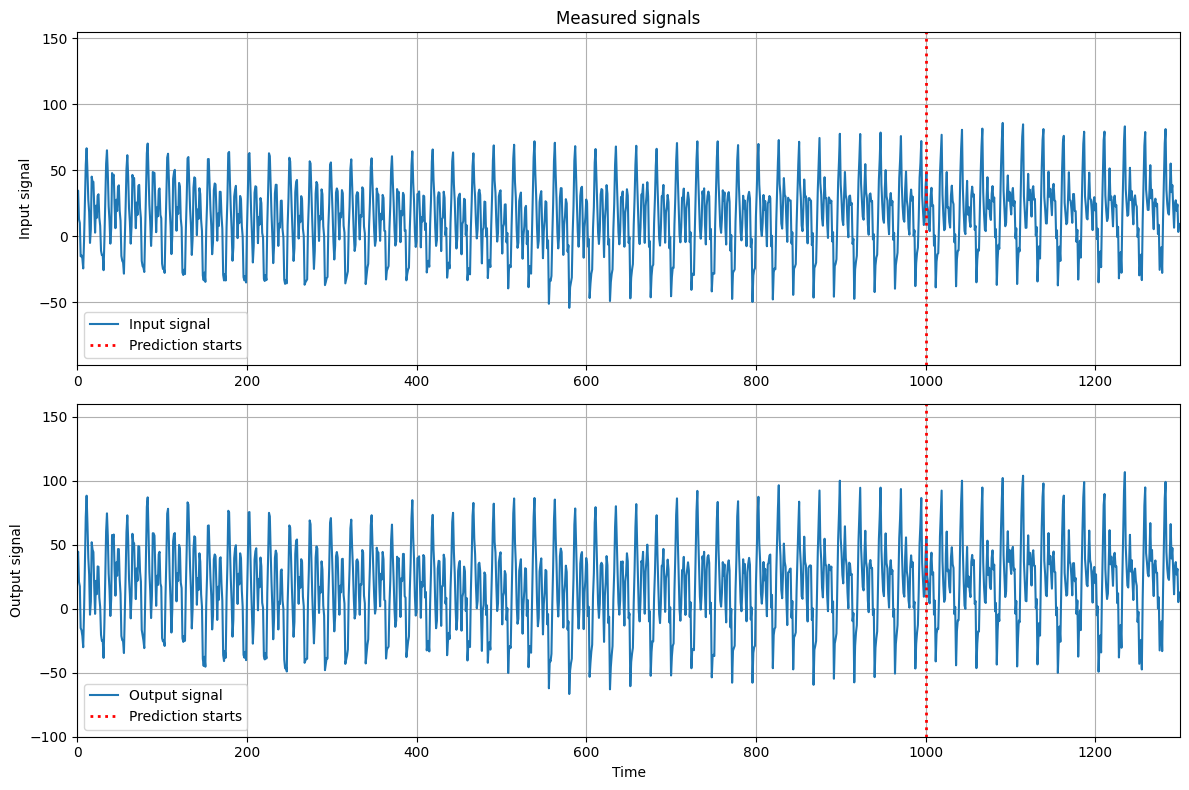

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(x)
ax1.axvline(x=modelLim, color='red', linestyle=':', linewidth=2)
ax1.set_xlim([0, N])
ax1.set_ylim([np.min(x)*1.8, np.max(x)*1.8])
ax1.set_ylabel('Input signal')
ax1.set_title('Measured signals')
ax1.legend(['Input signal', 'Prediction starts'], loc='lower left')
ax1.grid(True)

ax2.plot(y)
ax2.axvline(x=modelLim, color='red', linestyle=':', linewidth=2)
ax2.set_xlim([0, N])
ax2.set_ylim([np.min(y)*1.5, np.max(y)*1.5])
ax2.set_ylabel('Output signal')
ax2.set_xlabel('Time')
ax2.legend(['Output signal', 'Prediction starts'], loc='lower left')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Create a model for the input

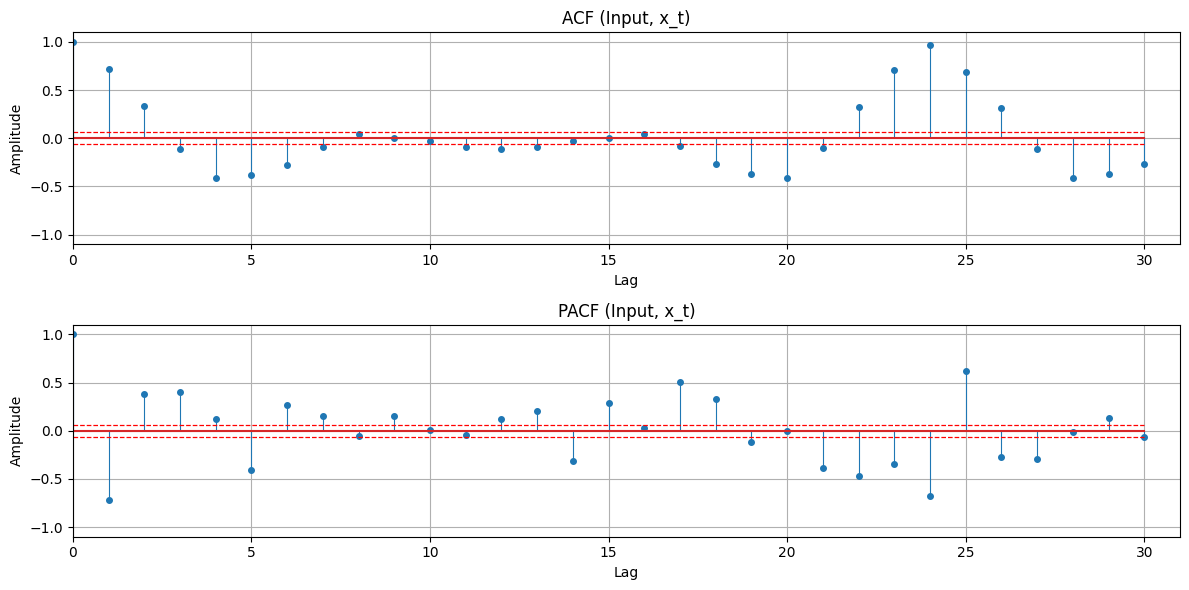

In [4]:
plotACFnPACF(xM, noLags, titleStr='Input, x_t')

## There seems to be a strong periodicity at 24, suggesting that a differentiation might help

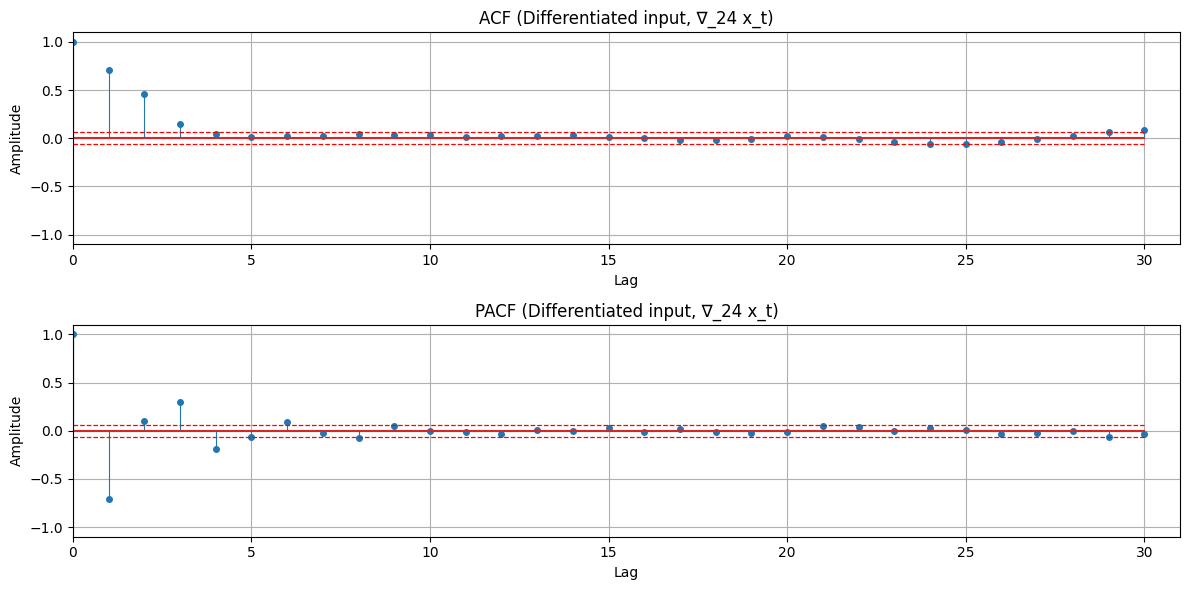

In [5]:
diff_xM = lfilter(np.concatenate([[1], np.zeros(sX-1), [-1]]), [1], xM)
diff_xM = diff_xM[sX+1:]
plotACFnPACF(diff_xM, noLags, titleStr=f'Differentiated input, ∇_{sX} x_t')

## Let's try add a1

Discrete-time AR model: A(z)y(t) = e(t)

A(z) = 1.0 - 0.7135(±0.0224)·z⁻¹

Polynomial orders: nA = 1
Number of free coefficients: 1
Fit to estimation data (NRMSE): 29.95%
FPE : 5.177  MSE : 5.166
AIC : 4365.564   BIC : 4370.445



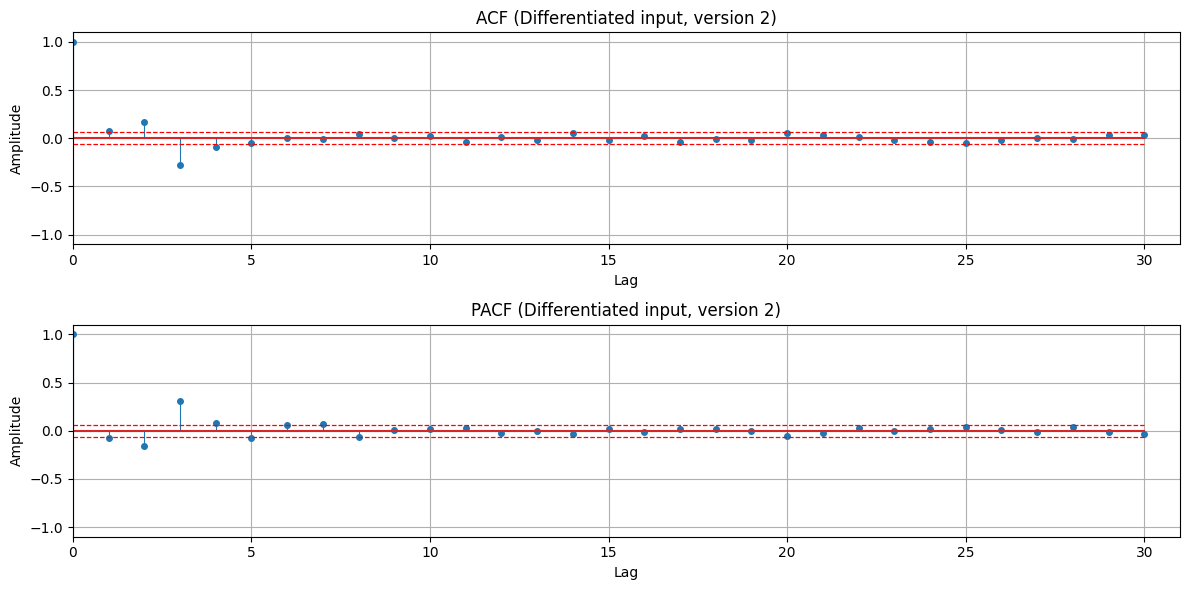

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 138.60 < 37.65)
  McLeod-Li test:        True (white if 35.34 < 37.65)
  Monti test:            False (white if 157.74 < 37.65)
  Sign change test:      True (white if 0.47 in [0.47,0.53])


In [6]:
estimateARMA(diff_xM, A=[1, 1], C=[1], titleStr='Differentiated input, version 2', noLags=noLags)

## We need c3, and perhaps c2?

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8178(±0.0212)·z⁻¹
C(z) = 1.0 - 0.384(±0.034)·z⁻³

Polynomial orders: nA = 1    nC = 3
Number of free coefficients: 2
Fit to estimation data (NRMSE): 33.89%
FPE : 4.619  MSE : 4.6
AIC : 4254.559   BIC : 4264.322



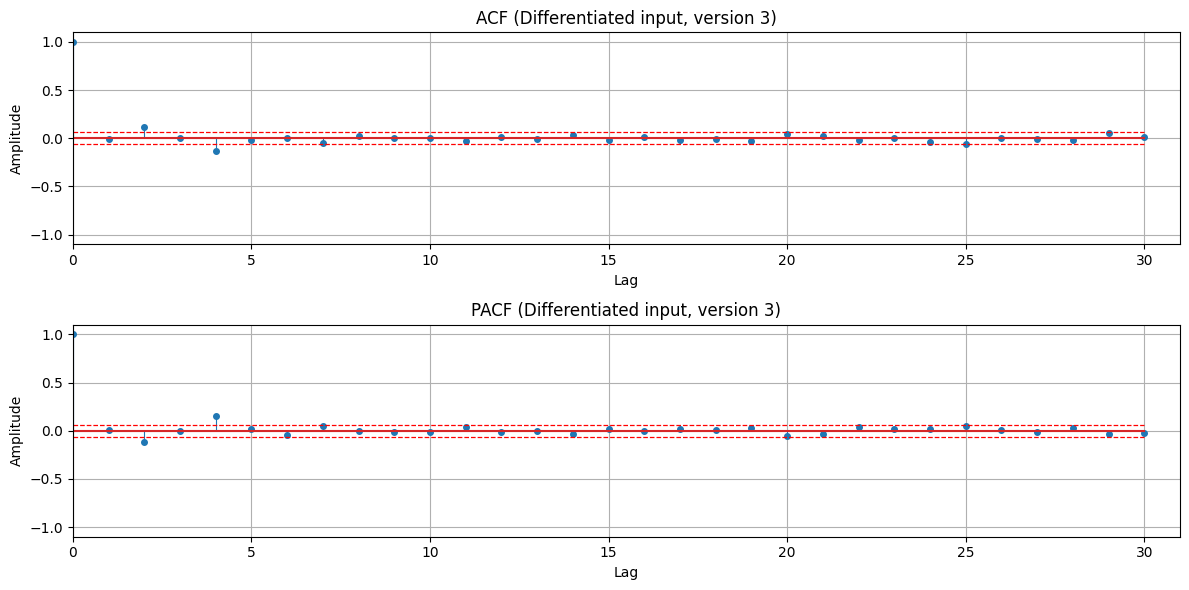

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 46.27 < 37.65)
  McLeod-Li test:        True (white if 22.96 < 37.65)
  Monti test:            False (white if 52.57 < 37.65)
  Sign change test:      True (white if 0.51 in [0.47,0.53])


In [7]:
estimateARMA(diff_xM, A=[1, 1], C=[1, 0, 0, 1], titleStr='Differentiated input, version 3', noLags=noLags)

## Ok, add c2 too... Maybe an a2 term as well...

Good, now it is white and all coefficients are significant.

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.8096(±0.0319)·z⁻¹ + 0.1683(±0.0424)·z⁻²
C(z) = 1.0 + 0.3177(±0.0423)·z⁻² - 0.2404(±0.039)·z⁻³

Polynomial orders: nA = 2    nC = 3
Number of free coefficients: 4
Fit to estimation data (NRMSE): 35.28%
FPE : 4.446  MSE : 4.41
AIC : 4212.982   BIC : 4232.504



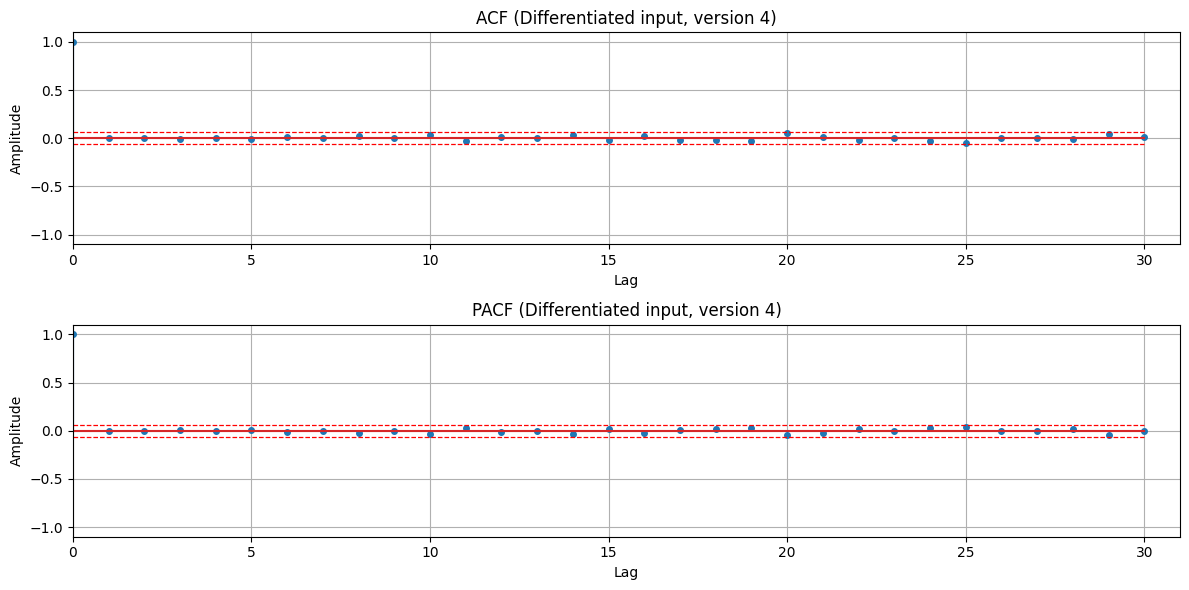

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 12.46 < 37.65)
  McLeod-Li test:        True (white if 21.02 < 37.65)
  Monti test:            True (white if 12.04 < 37.65)
  Sign change test:      True (white if 0.52 in [0.47,0.53])


In [8]:
inputModel = estimateARMA(diff_xM, A=[1, 1, 1], C=[1, 0, 1, 1], titleStr='Differentiated input, version 4', noLags=noLags)

## Create the BJ model

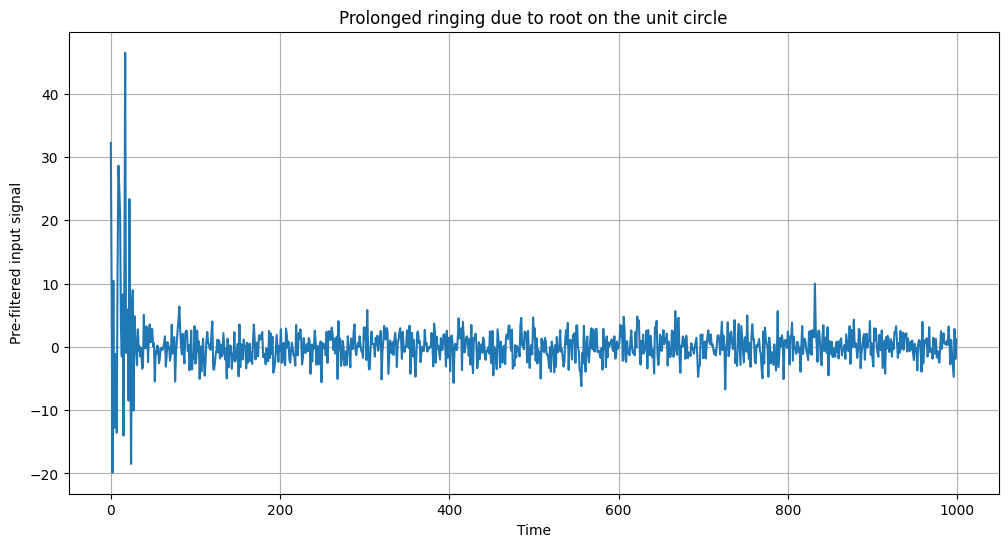

Note the importance of omitting the initial values!


In [9]:
# Add the differentiation to the model.
inputModel.A = np.convolve(np.concatenate([[1], np.zeros(sX-1), [-1]]), inputModel.A)

# Let's look at the residual
ex = lfilter(inputModel.A, inputModel.C, xM)

plt.figure(figsize=(12, 6))
plt.plot(ex)
plt.ylabel('Pre-filtered input signal')
plt.xlabel('Time')
plt.title('Prolonged ringing due to root on the unit circle')
plt.grid(True)
plt.show()

print('Note the importance of omitting the initial values!')

## Remember to remove the initial samples

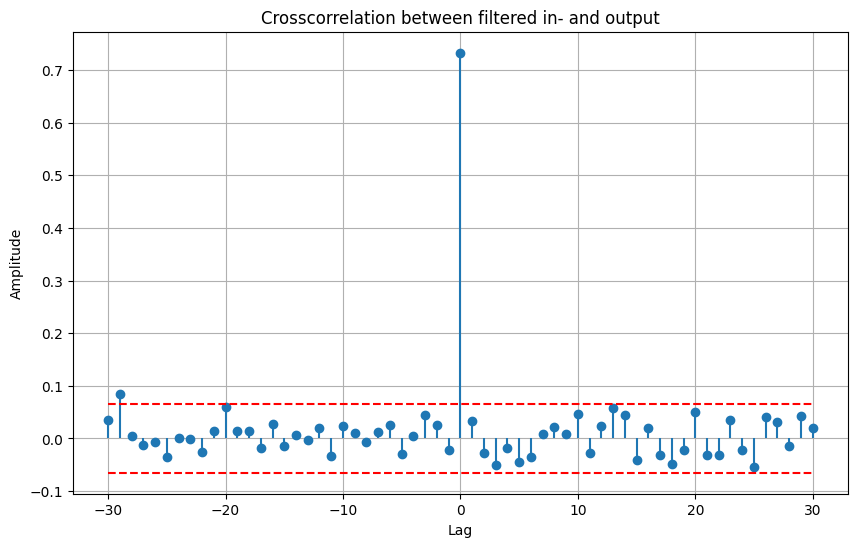

Seems like we only need b0.


In [10]:
# Re-filter both signals to get fresh ex and ey
ex = lfilter(inputModel.A, inputModel.C, xM)
ey = lfilter(inputModel.A, inputModel.C, yM)
ex = ex[len(inputModel.A)+30:]                  # Remove some more samples given the ringing (this is much more than needed).
ey = ey[len(inputModel.A)+30:]
var_ex = np.var(ex, ddof=0)

lags, Cxy = xcorr(ey, ex, maxlag=noLags, norm='coeff')

plt.figure(figsize=(10, 6))
plt.stem(lags, Cxy, basefmt=' ')
condInt = 2 * np.ones(len(lags)) / np.sqrt(len(ey))
plt.plot(lags, condInt, 'r--')
plt.plot(lags, -condInt, 'r--')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.title('Crosscorrelation between filtered in- and output')
plt.grid(True)
plt.show()

print('Seems like we only need b0.')

## Let's form an initial model

Discrete-time BJ model: y(t) = B(z)x(t) + e(t)

B(z) = 1.2037(±0.0039)

Polynomial orders: nB = 0
Number of free coefficients: 1
Fit to estimation data (NRMSE): 88.66%
FPE : 13.669  MSE : 13.654
AIC : 5453.925   BIC : 5458.833



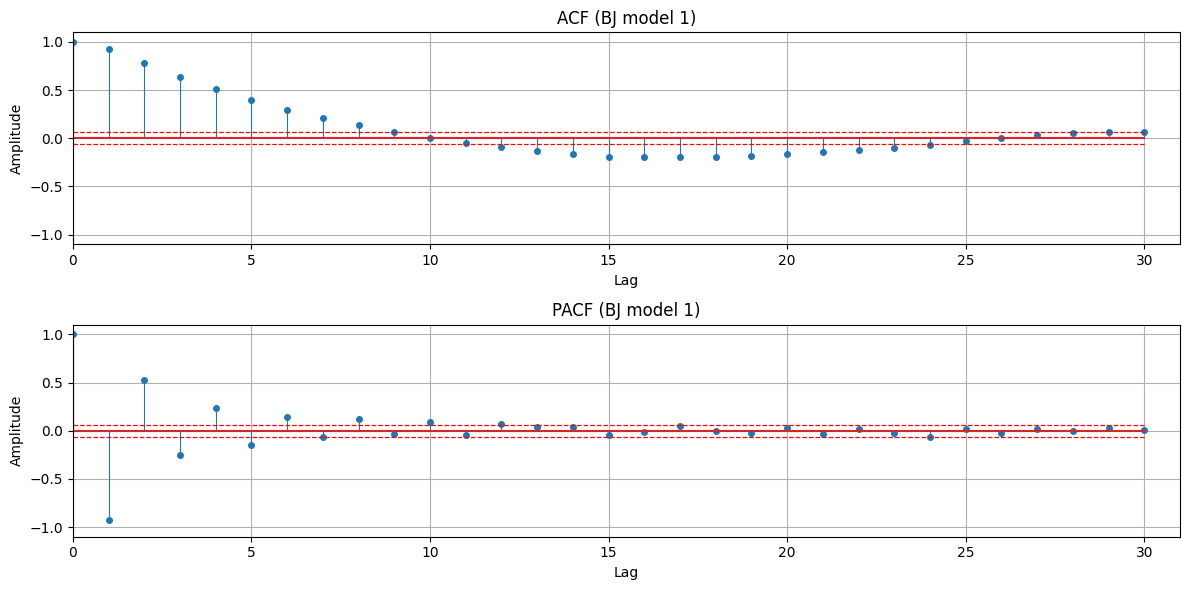

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 2765.59 < 37.65)
  McLeod-Li test:        False (white if 1868.58 < 37.65)
  Monti test:            False (white if 1355.34 < 37.65)
  Sign change test:      False (white if 0.13 in [0.47,0.53])
The input explains 98.7% of the variance.


In [11]:
# The function call is estimateBJ(y, x, B, A2, C1, A1, titleStr, noLags)
# Mapping: C1=C, A1=D, A2=F, B=B
foundModel_initial = estimateBJ(yM, xM, B=[1], A2=[1], C1=[1], A1=[1], titleStr='BJ model 1', noLags=noLags)
ey = foundModel_initial.resid
print(f'The input explains {100*(1-np.var(ey, ddof=0)/np.var(yM, ddof=0)):.1f}% of the variance.')

## Let's try to add a1 and a2

Discrete-time BJ model: y(t) = B(z)x(t) + [1/D(z)]e(t)

B(z) = 1.1991(±0.0019)
D(z) = 1.0 - 1.4316(±0.0263)·z⁻¹ + 0.5456(±0.0263)·z⁻²

Polynomial orders: nB = 0    nD = 2
Number of free coefficients: 3
Fit to estimation data (NRMSE): 96.43%
FPE : 1.36  MSE : 1.352
AIC : 3139.481   BIC : 3154.198



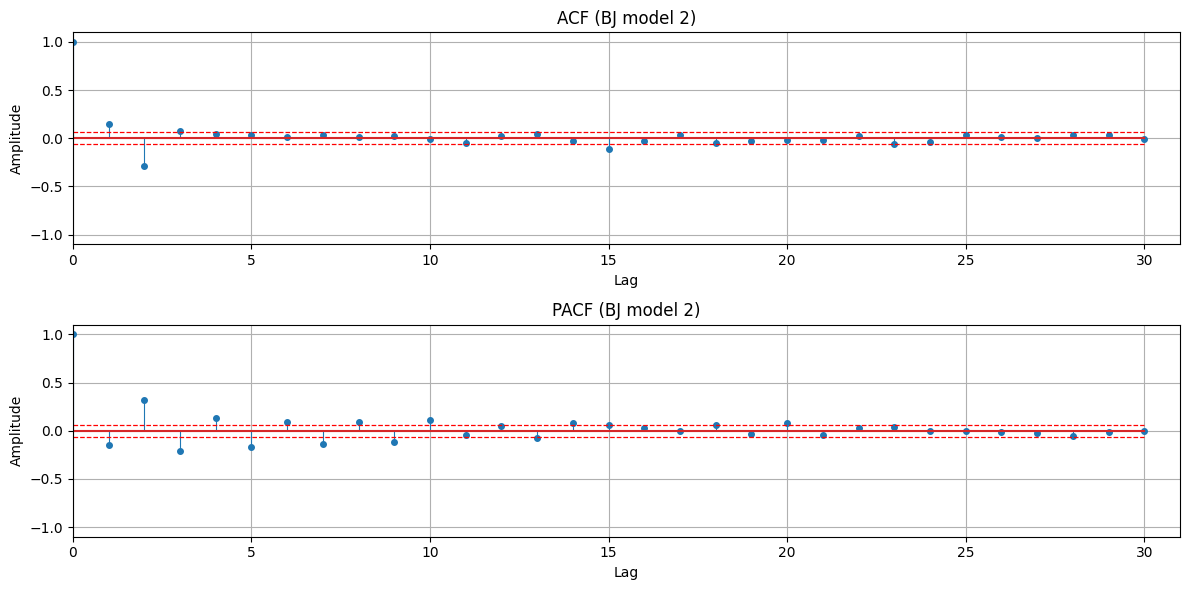

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 147.42 < 37.65)
  McLeod-Li test:        True (white if 17.29 < 37.65)
  Monti test:            False (white if 312.35 < 37.65)
  Sign change test:      False (white if 0.46 in [0.47,0.53])


In [12]:
estimateBJ(yM, xM, B=[1], A2=[1], C1=[1], A1=[1, 1, 1], titleStr='BJ model 2', noLags=noLags)

## Better... Maybe add a c2 term?

Yes, now it is white.

Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 1.2009(±0.0012)
C(z) = 1.0 - 0.0422(±0.061)·z⁻¹ - 0.7174(±0.0553)·z⁻²
D(z) = 1.0 - 1.7753(±0.0517)·z⁻¹ + 0.8042(±0.0425)·z⁻²

Polynomial orders: nB = 0    nC = 2    nD = 2
Number of free coefficients: 5
Fit to estimation data (NRMSE): 96.82%
FPE : 1.083  MSE : 1.072
AIC : 2911.751   BIC : 2936.28



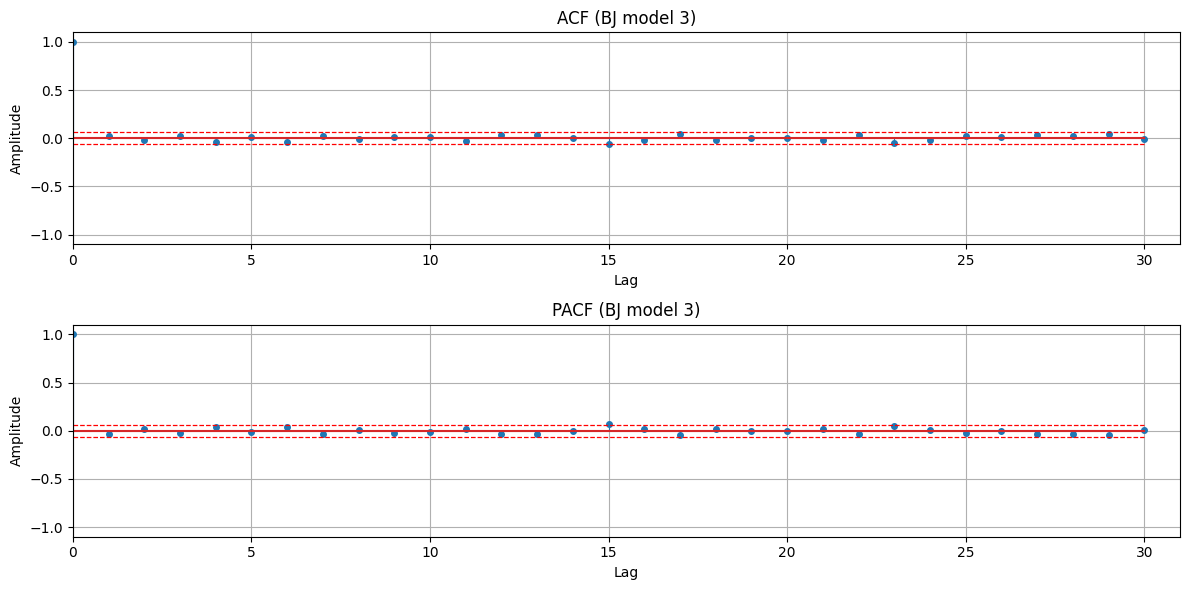

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 21.54 < 37.65)
  McLeod-Li test:        False (white if 58.73 < 37.65)
  Monti test:            True (white if 21.58 < 37.65)
  Sign change test:      True (white if 0.49 in [0.47,0.53])


In [13]:
foundModel = estimateBJ(yM, xM, B=[1], A2=[1], C1=[1, 0, 1], A1=[1, 1, 1], titleStr='BJ model 3', noLags=noLags)
ey = foundModel.resid
pacfEst = pacf(ey, noLags)

## We now have a white residual; can we trust the Monti test?

In [14]:
check_if_normal(pacfEst[1:])

The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


## How well does it work?

The model explains 99.9% of the variance.

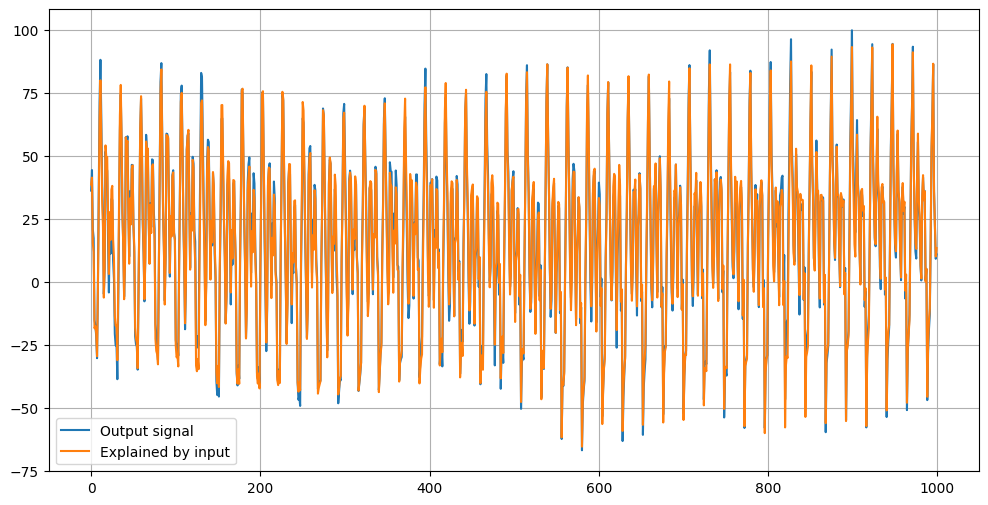

The input explains 98.7% of the variance.


In [15]:
# Check how much of the signal is explained by the model.
print(f'The model explains {100*(1-np.var(ey, ddof=0)/np.var(yM, ddof=0)):.1f}% of the variance.')

# It is always wise to plot the filtered input and compared it to the
# data. Also check how much the input now explains. Note that this example
# is selected to be well explained by the input; often it is not this good.
xS = lfilter(foundModel.B, foundModel.F, xM)

plt.figure(figsize=(12, 6))
plt.plot(yM, label='Output signal')
plt.plot(xS, label='Explained by input')
plt.legend()
plt.grid(True)
plt.show()

print(f'The input explains {100*(1-np.var(yM-xS, ddof=0)/np.var(yM, ddof=0)):.1f}% of the variance.')

## Let's predict the input first

Fx = [1.         0.80961868 0.80491562 0.2750472 ]
Gx = [ 0.00000000e+00  0.00000000e+00  5.55111512e-17  0.00000000e+00
  8.72345290e-02 -4.62841315e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.00000000e+00  0.00000000e+00  3.17710265e-01 -2.40387280e-01
 -8.72345290e-02  4.62841315e-02]


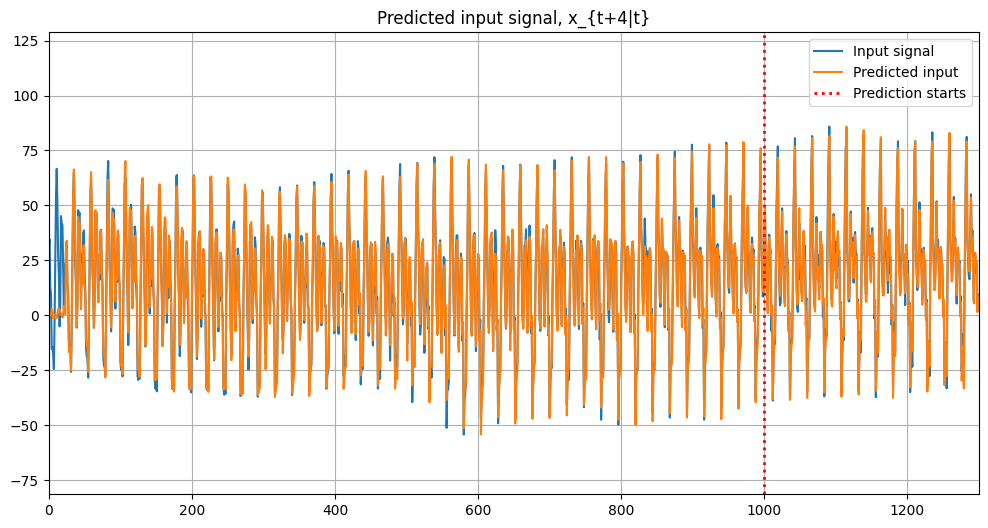

The theoretical std of the 4-step prediction error is 3.22.


In [16]:
k = 4
Fx, Gx = polydiv(inputModel.C, inputModel.A, k)
print(f"Fx = {Fx}")
print(f"Gx = {Gx}")

xhatk = lfilter(Gx, inputModel.C, x)

plt.figure(figsize=(12, 6))
plt.plot(x, label='Input signal')
plt.plot(xhatk, label='Predicted input')
plt.axvline(x=modelLim, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.legend()
plt.title(f'Predicted input signal, x_{{t+{k}|t}}')
plt.xlim([0, N])
plt.ylim([np.min(x)*1.5, np.max(x)*1.5])
plt.grid(True)
plt.show()

std_xk = np.sqrt(np.sum(Fx**2) * var_ex)
print(f'The theoretical std of the {k}-step prediction error is {std_xk:.2f}.')

## Form the residual. Is it behaving as expected?

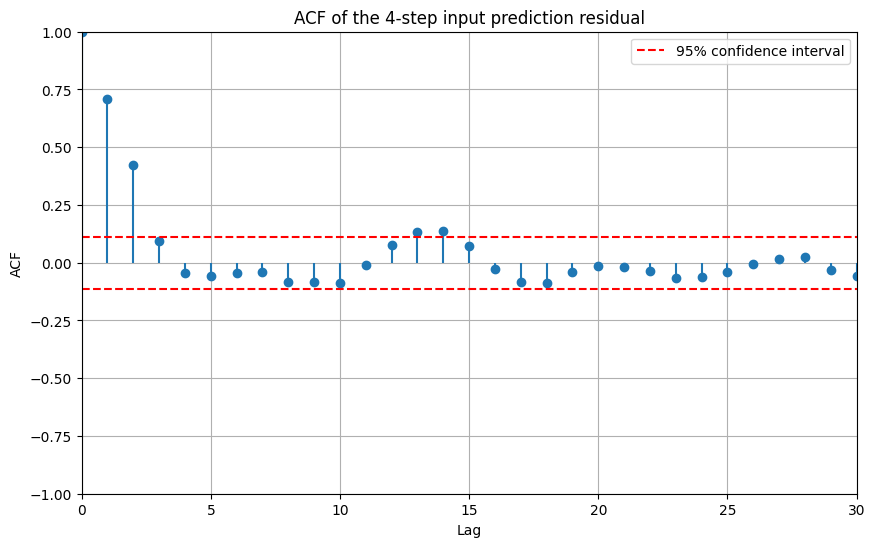

This is a 4-step prediction. Ideally, the residual should be an MA(3) process.
Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 241.86 < 37.65)
  McLeod-Li test:        False (white if 90.66 < 37.65)
  Monti test:            False (white if 213.06 < 37.65)
  Sign change test:      False (white if 0.23 in [0.44,0.56])
The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.


In [17]:
ehat = x - xhatk
ehat = ehat[modelLim:]

plt.figure(figsize=(10, 6))
acfEst = acf(ehat, noLags)
plt.stem(range(len(acfEst)), acfEst, basefmt=' ')
conf_int = 1.96 / np.sqrt(len(ehat))
plt.axhline(y=conf_int, color='r', linestyle='--', label='95% confidence interval')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.xlim([0, noLags])
plt.ylim([-1, 1])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title(f'ACF of the {k}-step input prediction residual')
plt.legend()
plt.grid(True)
plt.show()

print(f'This is a {k}-step prediction. Ideally, the residual should be an MA({k-1}) process.')
whiteness_test(ehat)
pacfEst = pacf(ehat, noLags)
check_if_normal(pacfEst[k:])

## Proceed to predict the data using the predicted input

Form the BJ prediction polynomials. In our notation, these are:
- A1 = foundModel.D
- C1 = foundModel.C
- A2 = foundModel.F

The KA, KB, and KC polynomials are formed as:
- KA = conv(A1, A2)
- KB = conv(A1, B)
- KC = conv(A2, C1)

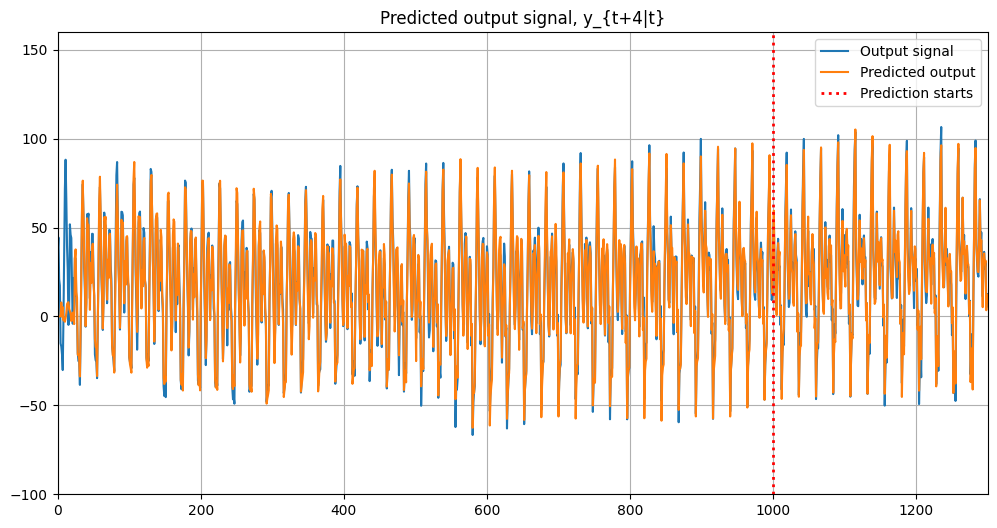

In [18]:
KA = np.convolve(foundModel.D, foundModel.F)
KB = np.convolve(foundModel.D, foundModel.B)
KC = np.convolve(foundModel.F, foundModel.C)

# Form the ARMA prediction for y_t, i.e., for the division C1/A1 (note that
# this is not the same G polynomial as we computed above (that was for x_t,
# this is for y_t).
#
# Remark:
# One could also compute this as KC/KA. This is in theory the same thing as
# KC/KA = C1/A1, but sometimes it can be easier to handle the
# larger polynomials (it does not know of the common A2 factor). In case
# you get odd results from your C1/A1 solution, it might thus actually be
# worth trying to compute KC/KA instead (it has been known to help!)
Fy, Gy = polydiv(foundModel.C, foundModel.D, k)

# Compute the \hat\hat{F} and \hat\hat{G} polynomials.
Fhh, Ghh = polydiv(np.convolve(Fy, KB), KC, k)

# Form the predicted output signal using the predicted input signal.
yhatk = lfilter(Fhh, [1], xhatk) + lfilter(Ghh, KC, x) + lfilter(Gy, KC, y)

# A very common error is to forget to add the predicted inputs. Let's try
# that to see what happens.
# yhatk = lfilter(Ghh, KC, x) + lfilter(Gy, KC, y)

plt.figure(figsize=(12, 6))
plt.plot(y, label='Output signal')
plt.plot(yhatk, label='Predicted output')
plt.axvline(x=modelLim, color='red', linestyle=':', linewidth=2, label='Prediction starts')
plt.legend()
plt.title(f'Predicted output signal, y_{{t+{k}|t}}')
plt.xlim([0, N])
plt.ylim([np.min(y)*1.5, np.max(y)*1.5])
plt.grid(True)
plt.show()

## What does the ACF look like - what should it look like?

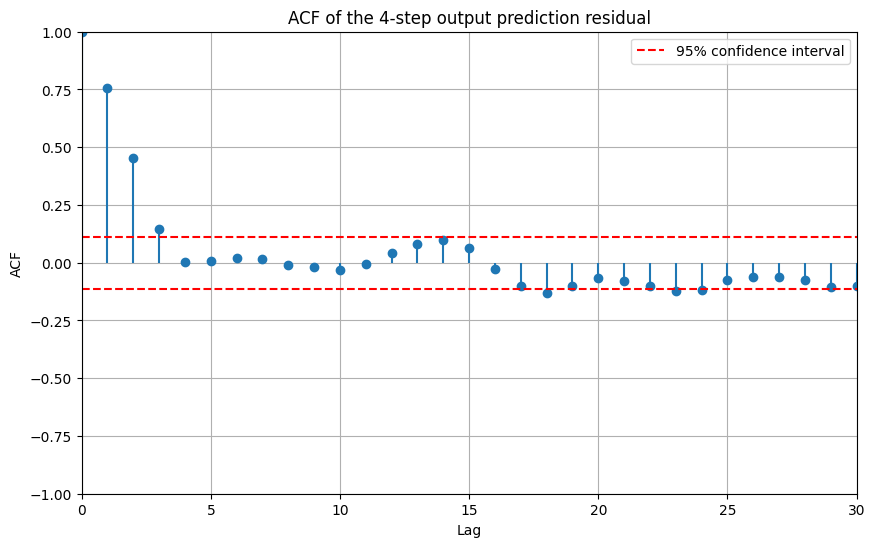

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: False (white if 279.24 < 37.65)
  McLeod-Li test:        False (white if 118.48 < 37.65)
  Monti test:            False (white if 250.37 < 37.65)
  Sign change test:      False (white if 0.20 in [0.44,0.56])
The D'Agostino-Pearson K2 test indicates that the data is NORMAL distributed.
Prediction results:
  The variance of the validations data is    1015.36
  The variance of the prediction residual is   27.68
  The prediction explains 97.3% of the variance


In [19]:
ehat = y - yhatk
ehat = ehat[modelLim:]
varY = np.var(y[modelLim:], ddof=0)

plt.figure(figsize=(10, 6))
acfEst = acf(ehat, noLags)
plt.stem(range(len(acfEst)), acfEst, basefmt=' ')
conf_int = 1.96 / np.sqrt(len(ehat))
plt.axhline(y=conf_int, color='r', linestyle='--', label='95% confidence interval')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.xlim([0, noLags])
plt.ylim([-1, 1])
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title(f'ACF of the {k}-step output prediction residual')
plt.legend()
plt.grid(True)
plt.show()

whiteness_test(ehat)
pacfEst = pacf(ehat, noLags)
check_if_normal(pacfEst[k:])

print('Prediction results:')
print(f'  The variance of the validations data is    {varY:7.2f}')
print(f'  The variance of the prediction residual is {np.var(ehat, ddof=0):7.2f}')
print(f'  The prediction explains {(1-np.var(ehat, ddof=0)/varY)*100:.1f}% of the variance')

## Let's compare with a naive predictor

As the data has a season of sX, a more suitable naive predictor when k>>1 might be to use the value at time t-sX+k. If your estimator is worse than this (it can easily happen!), then try to use the naive as your starting point, and then see if you can improve on it.

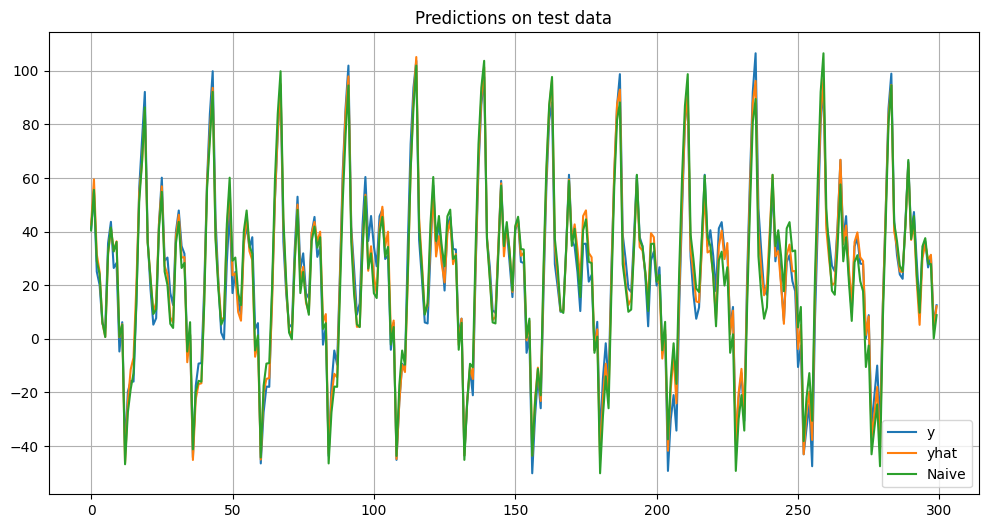

Naive predictor:
  The variance of the naive prediction residual is 57.58


In [20]:
testDataInd = np.arange(modelLim, N)
yNaive, var_naive, ehatN = naive_pred(y, testDataInd, k, season_k=sX)

plt.figure(figsize=(12, 6))
plt.plot(y[testDataInd], label='y')
plt.plot(yhatk[testDataInd], label='yhat')
plt.plot(yNaive, label='Naive')
plt.title('Predictions on test data')
plt.legend()
plt.grid(True)
plt.show()

print(f'Naive predictor:\n  The variance of the naive prediction residual is {var_naive:.2f}')
if var_naive > varY:
    print('  NOTE: This is higher than the variance of the data!!!')